In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import yfinance as yf

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
#from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *

In [148]:
data = pd.read_excel('data/Source Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')
#display(data)

spy_data = data[['Date', 'Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread']].dropna()
spy_data.set_index('Date', inplace=True)

#Transaform GDP variable into real terms
spy_data['GDP'] = spy_data['GDP'] / spy_data['PCEPI']

display(spy_data)

,Futures Shock,SPX Shock,1Y Treasury,SPX Total,GDP,PCEPI,Credit Spread
Date,,,,,,,
1992-01-01,0.000000,0.00000,4.03,408.8,100.828970,62.638,2.10
1992-02-01,0.004572,0.03621,4.06,412.7,101.223052,62.797,1.89
1992-03-01,0.000000,0.00000,3.98,403.7,101.940889,62.949,1.71
1992-04-01,-0.258935,0.61127,3.73,414.9,102.081101,63.119,1.73
1992-05-01,0.012382,-0.04802,3.82,415.4,101.795959,63.203,1.74
...,...,...,...,...,...,...,...
2023-09-01,0.051324,-0.17053,5.33,4288.1,229.449710,121.267,1.78
2023-10-01,0.000000,0.00000,5.33,4193.8,228.610941,121.309,1.83
2023-11-01,-0.013891,0.01259,5.33,4567.8,230.418379,121.296,1.79


[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'S&P 500 Price')

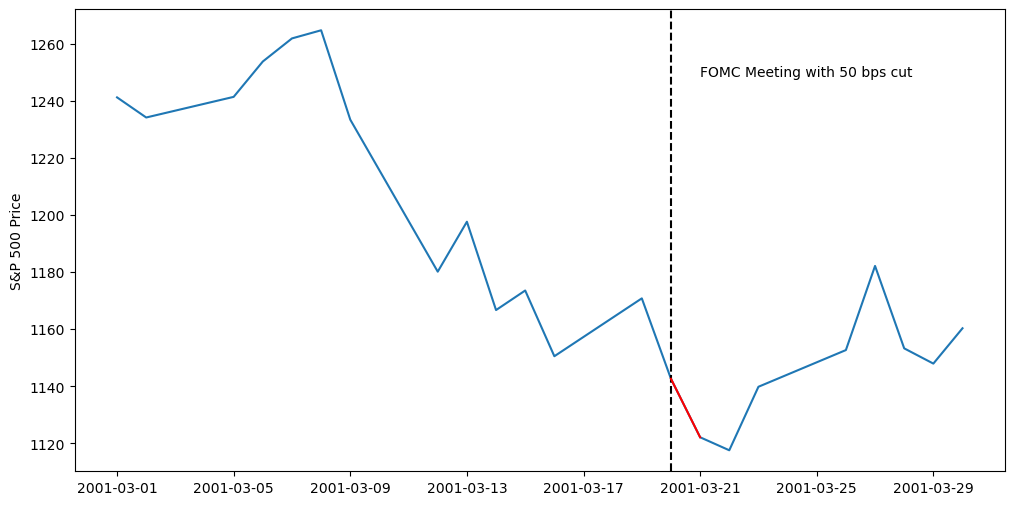

In [149]:
# Use yfinance to download the S&P 500 index between 15 Feb 2001 and 15 March 2001

start_date = '2001-03-01'
end_date = '2001-03-31'
spx = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']

plt.figure(figsize=(12, 6))
plt.plot(spx)

# Find the next trading day after 3 March 2001
fomc_date = pd.Timestamp('2001-03-20')

# Add a black vertical line at the date of the FOMC meeting
plt.axvline(x=fomc_date, color='black', linestyle='--')

#label the dotted line as the FOMC meeting with rate cut, move the label a few pixels to the right
plt.text(pd.Timestamp('2001-03-21'), 1250, 'FOMC Meeting with 50 bps cut',verticalalignment='center')

#plot a red line for the price change on the fomc meeting day and the following day
signal = spx.loc[[fomc_date, fomc_date + pd.Timedelta(days=1)]]  # Select the price on the FOMC meeting day and the following day
plt.plot(signal.index, signal, color='red')

#label y axis S&P 500 Price
plt.ylabel('S&P 500 Price')

Text(0.15, -1.5, 'IV: 78')

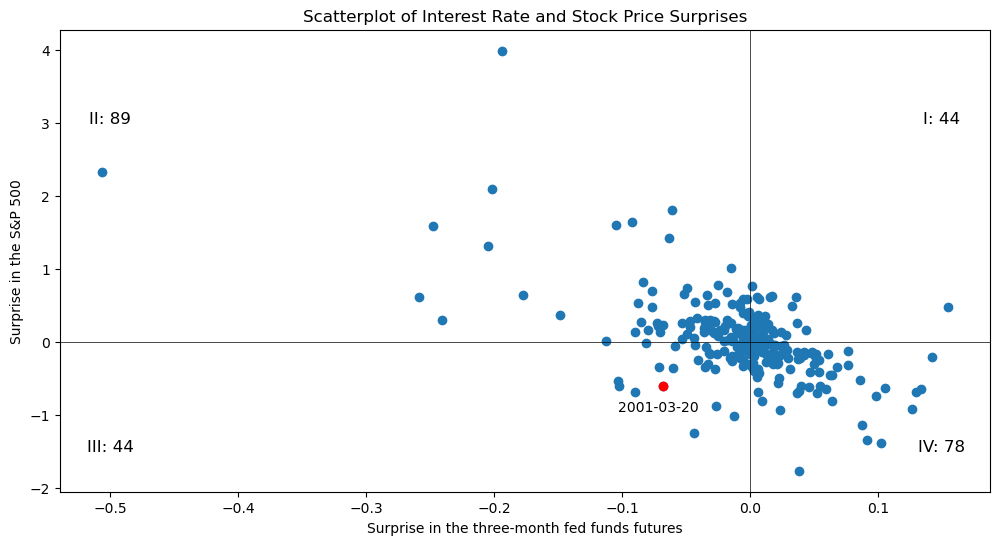

In [150]:
shocks = spy_data[['Futures Shock', 'SPX Shock']]

#Create scatter plot of the shocks
plt.figure(figsize=(12, 6))
plt.scatter(shocks['Futures Shock'], shocks['SPX Shock'])
plt.xlabel('Surprise in the three-month fed funds futures')
plt.ylabel('Surprise in the S&P 500')
plt.title('Scatterplot of Interest Rate and Stock Price Surprises')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

#Make the scatter plot of the shocks with the FOMC meeting day in red
fomc_date = pd.Timestamp('2001-03-01')
signal = shocks.loc[[fomc_date]]
plt.scatter(signal['Futures Shock'], signal['SPX Shock'], color='red')
plt.text(-0.04, -1, '2001-03-20', verticalalignment='bottom', horizontalalignment='right')


#Count the number of observations in each quadrant
quadrants = np.sign(shocks)
quadrants['count'] = 1
quadrants = quadrants.groupby(['Futures Shock', 'SPX Shock']).count().reset_index()
quadrants = quadrants.pivot(index='SPX Shock', columns='Futures Shock', values='count').fillna(0)
quadrants = quadrants.astype(int)

#label each quadrant I, II, III, IV
plt.text(0.15, 3, f'I: {quadrants.loc[1,1]}', fontsize=12, ha='center')
plt.text(-0.5, 3, f'II: {quadrants.loc[1,-1]}', fontsize=12, ha='center')
plt.text(-0.5, -1.5, f'III: {quadrants.loc[-1,-1]}', fontsize=12, ha='center')
plt.text(0.15, -1.5, f'IV: {quadrants.loc[-1,1]}', fontsize=12, ha='center')

In [151]:
# ADF TEST
# List of column names to check for stationarity
columns_to_check = ['Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread']

# Function to run ADF test and print results
def adf_test(series, column_name):
    result = adfuller(series, regression='c')
    print(f'ADF Test for {column_name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')
    print('\n')

# Apply the ADF test to each column
for col in columns_to_check:
    adf_test(spy_data[col], col)

ADF Test for Futures Shock:
ADF Statistic: -6.26718897644418
p-value: 4.0867502239440795e-08
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for SPX Shock:
ADF Statistic: -10.939377958721089
p-value: 9.380401628747977e-20
Critical Values:
    1%: -3.4477686860685
    5%: -2.869216670067509
    10%: -2.570859500573892


ADF Test for 1Y Treasury:
ADF Statistic: -2.526655868973357
p-value: 0.1091226279837903
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for SPX Total:
ADF Statistic: 2.090140345011109
p-value: 0.9987792198527747
Critical Values:
    1%: -3.448343869853195
    5%: -2.869469418606909
    10%: -2.570994248260623


ADF Test for GDP:
ADF Statistic: 0.4883346528802354
p-value: 0.9845141914723283
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for PCEPI:
ADF Statistic: 2.341392830693939
p-

In [152]:
# List of columns to check for stationarity
#columns_to_check = ['Futures Shock', 'M2SL', 'PCEPI', 'FEDFUNDS', 'GDP', 'Unemployment', 'SPX Total']
columns_to_check = ['Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread']

# Function to conduct ADF tests and identify non-stationary variables
def check_stationarity(data, columns_to_check):
    non_stationary_cols = []
    for col in columns_to_check:
        result = adfuller(data[col].dropna(), regression='c')
        if result[1] > 0.05:  # p-value greater than 0.05 indicates non-stationarity
            non_stationary_cols.append(col)
        print(f"{col}: ADF Statistic = {result[0]}, p-value = {result[1]}")
    return non_stationary_cols

## Creating CSV file for MATLAB implementation

1 year treasury is non stationary and can cause problems

In [153]:
VARdata = spy_data.copy()
from scipy import signal
# These Variables in the Paper are in log * 100
for col in ['SPX Total', 'GDP', 'PCEPI']:
    VARdata[col] = np.log(spy_data[col]) * 100

# Apply detrend function to '1Y Treasury' values
#VARdata['1Y Treasury'] = signal.detrend(spy_data['1Y Treasury'].values)

# Create Columns 'year' and 'month' taken from the index
VARdata['year'] = VARdata.index.year
VARdata['month'] = VARdata.index.month

# Place the year and month column as first and second in the df
cols = VARdata.columns.tolist()
cols = cols[-2:] + cols[:-2]
VARdata = VARdata[cols]

#VARdata = VARdata[cols].reset_index(drop=True)

# Rename the columns 
VARdata.columns = ['year', 'month', 'ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']

In [154]:
columns_to_check = ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']
non_stationary_cols = check_stationarity(VARdata, columns_to_check)
print(f"Non-stationary columns: {non_stationary_cols}")

ff4_hf: ADF Statistic = -6.26718897644418, p-value = 4.0867502239440795e-08
sp500_hf: ADF Statistic = -10.939377958721089, p-value = 9.380401628747977e-20
gs1: ADF Statistic = -3.708174578196648, p-value = 0.00399962963823592
logsp500: ADF Statistic = -0.5669306166339858, p-value = 0.878280654429874
us_rgdp: ADF Statistic = -1.4549891546130753, p-value = 0.5556485667120343
us_gdpdef: ADF Statistic = 1.137147552020317, p-value = 0.9955215188741736
ebpnew: ADF Statistic = -3.6159619143239854, p-value = 0.00546310105899709
Non-stationary columns: ['logsp500', 'us_rgdp', 'us_gdpdef']


In [155]:
# Original paper has interest rate as I(0) variable

#Save as a csv file
VARdata.to_csv('data/VARdata.csv', index=False)

In [156]:
#store in a df the min and max values for each column
min_max = pd.DataFrame(index=['min', 'max'], columns=VARdata.columns[2:])
min_max.loc['min'] = VARdata[columns_to_check].min()
min_max.loc['max'] = VARdata[columns_to_check].max()
min_max


#unemp, Unemployment rate\newline(%),0,0,0.15

,ff4_hf,sp500_hf,gs1,logsp500,us_rgdp,us_gdpdef,ebpnew
min,-0.506441,-1.76769,-2.252681,600.067203,461.342571,413.737212,1.29
max,0.154256,3.99301,4.977099,848.582636,544.720945,480.325026,6.01


## Lag order Selection

In [157]:
# Apply differencing
for col in ['logsp500', 'us_rgdp', 'us_gdpdef']:
    VARdata[col] = VARdata[col].diff()
    
#VARdata['gs1'] = VARdata['gs1'].diff()
    
VARdata.dropna(inplace=True)

plt.figure(figsize=(12, 6))

for column in ['gs1', 'logsp500', 'us_rgdp', 'us_gdpdef']:
    plt.figure()
    plt.plot(VARdata[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Value')
plt.show()


In [158]:
#Put all the stationarity test results in a table with the adf statistic and p-values
columns_to_check_ = ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']

adf_results = []
for col in columns_to_check_:
    result = adfuller(VARdata[col])
    adf_results.append([col, result[0], result[1]])
adf_results = pd.DataFrame(adf_results, columns=['Variable', 'ADF Statistic', 'p-value'])

# export as an xlsx file
adf_results.to_excel('data/adf_results.xlsx')

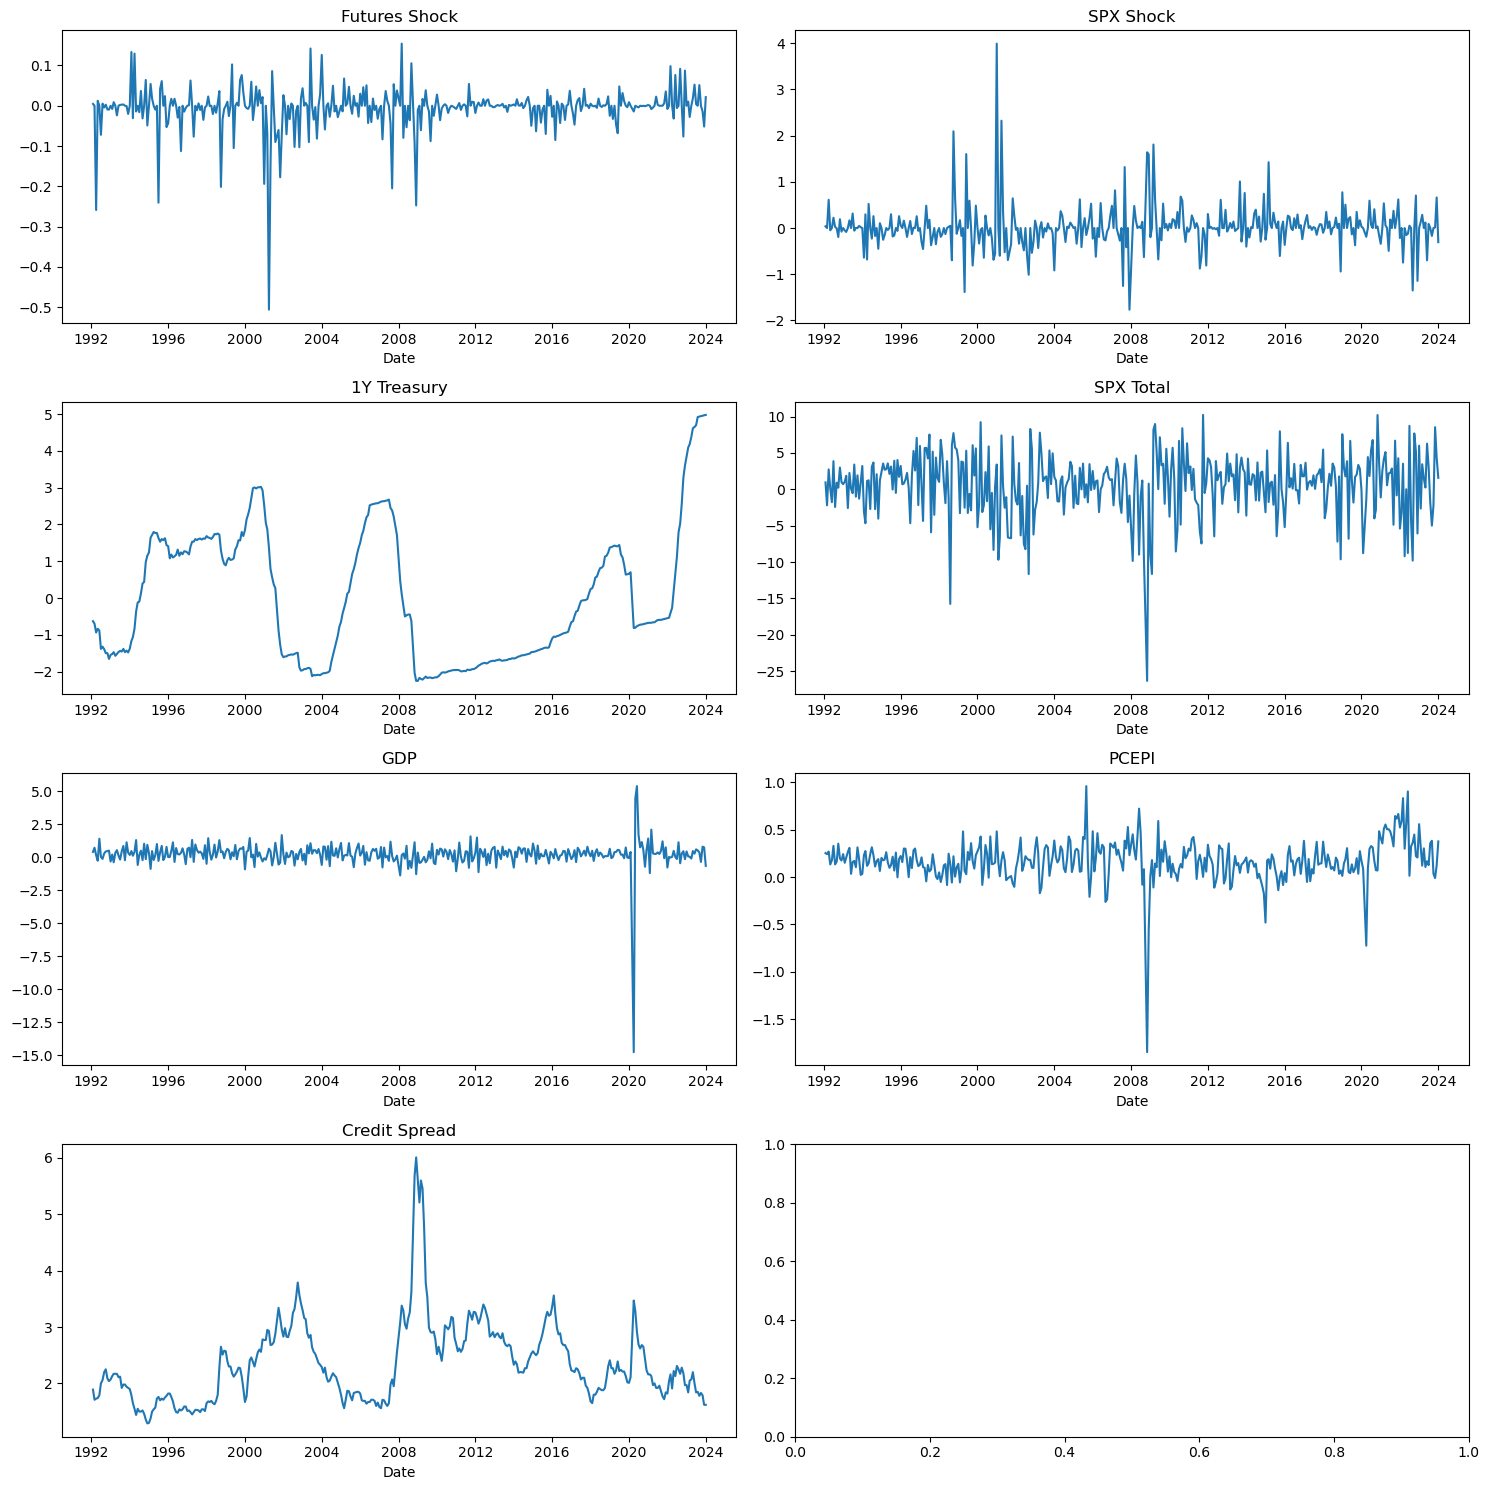

In [159]:
#Plot 'M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total'
fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for i, col in enumerate(columns_to_check_):
    labels = ['Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread', 'Unemployment']
    label = labels[i]
    ax = axs[i//2, i%2]
    ax.plot(VARdata[col])
    ax.set_title(label)
    # set x axis to the index
    ax.set_xlabel('Date')

plt.tight_layout()

In [160]:
# Initialize and fit the VAR model
model_var = VAR(VARdata[['gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']], exog=VARdata[['ff4_hf', 'sp500_hf'] ])
lag_selection = model_var.select_order(maxlags=24)
optimal_lags = lag_selection.aic
optimal_lags

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


4

Lag order of 12 in line with the Prior literature.

Original paper (Marek Jarociński and Peter Karadi (2018)) and Silvia Miranda-Agrippino and Giovanni Ricco (2021) both use the same lag order

We see from the table below that the ICs are not in agreement, we could argue that a lag order of 1 is valid. Since we do not need to impose a penalty for higher orders, AIC is the chosen criterion

In [161]:
lag_selection.summary()

,AIC,BIC,FPE,HQIC
0,-0.09634,0.06693,0.9082,-0.03139
1,-7.772,-7.337,0.0004213,-7.599
2,-8.072,-7.365*,0.0003121,-7.791*
3,-8.083,-7.104,0.0003088,-7.694
4,-8.174*,-6.923,0.0002820*,-7.677
5,-8.138,-6.614,0.0002928,-7.531
6,-8.080,-6.284,0.0003106,-7.365
7,-8.092,-6.024,0.0003072,-7.269
8,-8.010,-5.669,0.0003342,-7.079
9,-8.038,-5.426,0.0003256,-6.999


In [162]:
# Fit the VAR model with the chosen lag length
var_results = model_var.fit(12)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     23:28:53
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -4.67087
Nobs:                     368.000    HQIC:                  -6.68708
Log likelihood:          -820.883    FPE:                0.000335770
AIC:                     -8.01611    Det(Omega_mle):     0.000152368
--------------------------------------------------------------------
Results for equation gs1
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.138643         0.079456            1.745           0.081
ff4_hf                0.639620         0.243978            2.622           0.009
sp500_hf              0.007054         0.025591            0.2

In [163]:
# Fit the VAR model with the chosen lag length
var_results = model_var.fit(optimal_lags)
print(var_results.summary())

#fevd = var_results.fevd() works for VAR but not SVAR
#fevd.plot(10)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     23:28:53
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -7.14559
Nobs:                     376.000    HQIC:                  -7.87036
Log likelihood:          -983.283    FPE:                0.000237180
AIC:                     -8.34746    Det(Omega_mle):     0.000176259
--------------------------------------------------------------------
Results for equation gs1
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.106202         0.053477            1.986           0.047
ff4_hf               0.607884         0.230475            2.638           0.008
sp500_hf            -0.002856         0.024196           -0.118   

At this point, we run the SVAR with exogeneity conditions and sign restrictions using the original code from the paper found at: replication_file/work_matlab/main1.m

All the replication files are in MATLAB which requires a license.

We adapted the script in the file for our needs, namely we only use the sign restriction method and we the Gibbs Sampler to predict surprises in period where There is no FOMC meeting. However, we put in much less draws than the original paper in order to make it less computationally intensive.

all that is needed is to change the directories in the script and run the matlab code.

In [164]:
roots = var_results.roots

all_stable = all(np.abs(root) > 1 for root in roots)
if all_stable:
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

The VAR model is stable.


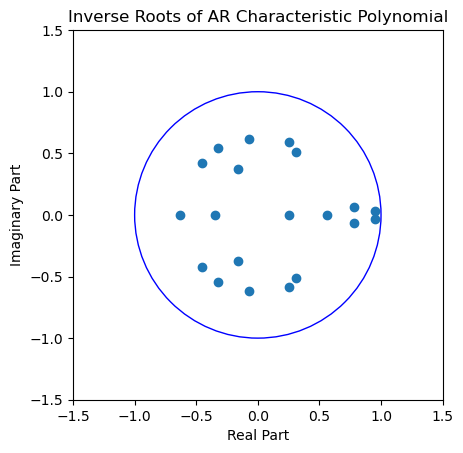

In [165]:
# Calculate inverse roots
inverse_roots = 1 / roots

# Create a new figure
plt.figure()

# Plot the real part on the x-axis and the imaginary part on the y-axis
plt.scatter(inverse_roots.real, inverse_roots.imag)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Set the x and y limits to be the same
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

# Set the aspect ratio to be equal, so the circle looks like a circle
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Inverse Roots of AR Characteristic Polynomial')

# Show the plot
plt.show()

In [166]:
# Assuming `svar_results` is the fitted results object
# Retrieve residuals and variable names from the fitted SVAR results
residuals = var_results.resid
variable_names = var_results.names

# Example of the Jarque-Bera test for normality
from scipy.stats import jarque_bera

for i, var in enumerate(variable_names):
    jb_test = jarque_bera(residuals[:, i])
    print(f"Normality Test for {var}: Statistic={jb_test[0]}, p-value={jb_test[1]}")

# we need to correct outliers, variables deviate from normality

InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
print(svar_results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 39864.081, critical value: 23.685>, p-value: 0.000>


In [ ]:
print(svar_results.test_whiteness())

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 687.762, critical value: 490.960>, p-value: 0.000>


In [ ]:
#granger causality

In [ ]:
import statsmodels.stats.diagnostic as smd
import pandas as pd

# Access the residuals and predictor variables from the fitted SVAR model
residuals = pd.DataFrame(svar_results.resid, columns=svar_results.names)

# Retrieve endogenous variables used as predictors
predictors = pd.DataFrame(svar_results.endog, columns=svar_results.names)

# Conduct the White test for each residual series
for i, col in enumerate(residuals.columns):
    white_test = smd.het_white(residuals[col], predictors)
    print(f"White Test for {col}: LM Statistic={white_test[0]}, p-value={white_test[1]}")


ValueError: resid is required to have shape (384, 1) but has shape (383, 1)

In [ ]:
# Example of performing the Breusch-Godfrey test for autocorrelation
import statsmodels.stats.diagnostic as smd

# Perform the Breusch-Godfrey test
lm_test = smd.acorr_breusch_godfrey(svar_results, nlags=10)

# Print the results of the test
print(f"Breusch-Godfrey Test: LM Statistic={lm_test[0]}, p-value={lm_test[1]}")


ValueError: Model resid must be a 1d array. Cannot be used on multivariate models.

<Axes: title={'center': 'Local Projection for SPX Total'}, xlabel='Horizon (Periods Ahead)', ylabel='Response'>

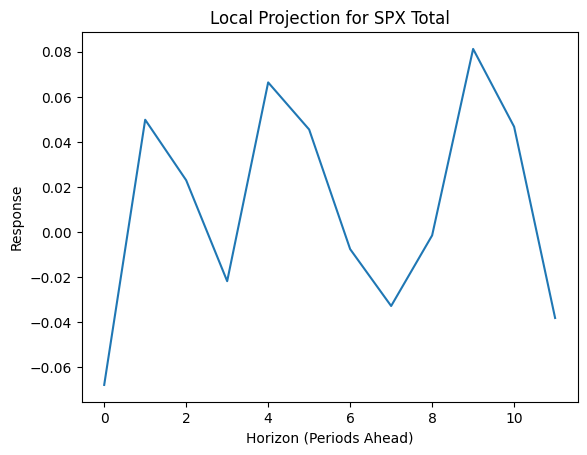

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Set the shock variable (assumed exogenous)
shock_variable = 'Futures Shock'

horizons = range(0, 12)

# Initialize a dictionary to store results for each response variable
responses = {var: [] for var in spy_data_ordered.columns if var != shock_variable}

# Fit a local projection model for each horizon and response variable
for h in horizons:
    for response_var in responses:
        # Shift the response variable by the horizon value
        target = spy_data_ordered[response_var].shift(-h).dropna()

        # Ensure predictors are aligned with the shifted target
        predictors = spy_data_ordered[[shock_variable]].loc[target.index]

        # Add a constant term to predictors
        predictors = sm.add_constant(predictors)

        # Fit an Ordinary Least Squares (OLS) regression
        model = sm.OLS(target, predictors).fit()

        # Append the coefficient for the shock variable
        responses[response_var].append(model.params[shock_variable])

# Convert responses to a DataFrame for easier analysis
response_df = pd.DataFrame(responses, index=horizons)

response_df['SPX Total'].plot(title="Local Projection for SPX Total", xlabel="Horizon (Periods Ahead)", ylabel="Response")

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults

# Assuming 'data' is a dictionary containing the required variables

# Concatenate all the variables into a DataFrame
df = pd.DataFrame(data['y'], columns=[f'y{i+1}' for i in range(data['y'].shape[1])])
df['m'] = spy_data_ordered[['Futures Shock', 'SPX Shock']].values.flatten()
df = pd.concat([df, pd.DataFrame(data['w'], columns=[f'w{i+1}' for i in range(data['w'].shape[1])])], axis=1)

# Assuming df is your DataFrame

# Fit VAR model
model = VAR(df)
results = model.fit(maxlags=prior['lags'])

# Extract posterior results
beta = results.coefs
sigma = results.sigma_u

# Assuming 'ndraws' is the number of posterior draws
beta_draws = np.empty((beta.shape[0], beta.shape[1], ndraws))
sigma_draws = np.empty((sigma.shape[0], sigma.shape[1], ndraws))

for i in range(ndraws):
    # Simulate residuals
    residuals = np.random.multivariate_normal(np.zeros(N), sigma, T)

    # Simulate data
    simulated_data = np.zeros((T, N))
    simulated_data[:prior['lags'], :] = data['y'][:prior['lags'], :]
    for t in range(prior['lags'], T):
        lagged_data = np.concatenate([simulated_data[t-1:t-prior['lags']-1:-1, :], data['w'][t-1:t-prior['lags']-1:-1, :]], axis=1)
        simulated_data[t, :] = np.dot(beta.T, lagged_data[t, :]) + residuals[t, :]

    # Fit VAR model to simulated data
    model = VAR(pd.DataFrame(simulated_data, columns=df.columns))
    results = model.fit(maxlags=prior['lags'])

    # Store posterior draws
    beta_draws[:, :, i] = results.coefs
    sigma_draws[:, :, i] = results.sigma_u


KeyError: 'y'